In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, precision_score,recall_score, mean_squared_error
from sklearn.metrics import  confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
from itertools import combinations
from scipy.stats import pearsonr, chi2_contingency
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import sklearn.metrics as metrics
import matplotlib.patches as  mpatches
import timeit
from sklearn.metrics import roc_auc_score


Load data

In [21]:
df = pd.read_csv("/kaggle/input/lendingclub/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv", parse_dates=['issue_d'], infer_datetime_format=True)
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df.head())
df = df[(df.issue_d >= '2018-01-01 00:00:00') ]
df = df.sample(n=200000)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,N

Plotting the subgrade plot by counted values

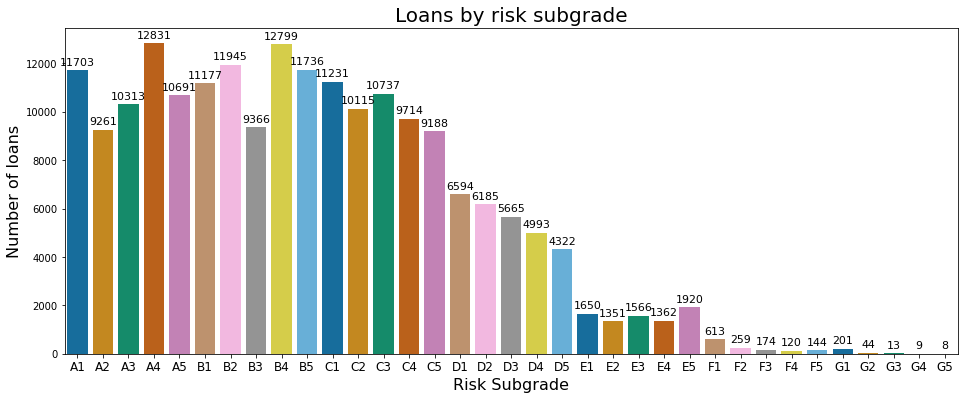

In [22]:
fig = plt.figure(figsize = (16,6))
ax = sns.countplot(x ='sub_grade',data=df, 
                   order = ['A1', 'A2', 'A3', 'A4', 'A5',
                            'B1', 'B2', 'B3', 'B4', 'B5',
                            'C1', 'C2', 'C3', 'C4', 'C5',
                            'D1', 'D2', 'D3', 'D4', 'D5',
                            'E1', 'E2', 'E3', 'E4', 'E5',
                            'F1', 'F2', 'F3', 'F4', 'F5',
                            'G1', 'G2', 'G3', 'G4', 'G5'], 
                   palette='colorblind')
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
plt.xticks(fontsize=12)
ax.set_xlabel("Risk Subgrade", fontsize = 16)
ax.set_ylabel("Number of loans", fontsize = 16)
ax.set_title("Loans by risk subgrade", fontsize = 20)
plt.show()

# Prediction model for Grade

Define column names I will be using in prediction model.

In [23]:
numerical_features = [
    'acc_now_delinq', 'acc_open_past_24mths', 'all_util', 'annual_inc',
       'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'dti_joint', 'fico_range_high', 'fico_range_low', 'funded_amnt',
       'funded_amnt_inv', 'hardship_amount', 'hardship_dpd',
       'hardship_last_payment_amount', 'hardship_payoff_balance_amount',
       'il_util', 'inq_fi', 'inq_last_12m', 'inq_last_6mths',
       'installment', 'last_fico_range_high',
       'last_fico_range_low', 'last_pymnt_amnt', 'loan_amnt',
       'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_last_major_derog',
       'mths_since_last_record', 'mths_since_rcnt_il',
       'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'open_rv_12m', 'open_rv_24m',
       'orig_projected_additional_accrued_interest', 'out_prncp',
       'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec',
       'pub_rec_bankruptcies', 'recoveries', 'revol_bal',
       'revol_bal_joint', 'revol_util',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med', 'sec_app_fico_range_high',
       'sec_app_fico_range_low', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog',
       'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il',
       'sec_app_revol_util', 'settlement_amount', 'settlement_percentage',
       'settlement_term', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal',
       'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort',
       'total_bal_il', 'total_bc_limit', 'total_cu_tl',
       'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp',
       'total_rev_hi_lim'
]
categorical_features = [
       'term', 'emp_length',
       'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan',
       'purpose', 'title',
       'initial_list_status', 'last_pymnt_d',
       'verification_status_joint',
       'hardship_flag', 'hardship_reason',
       'hardship_status', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_loan_status',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'
]
label_column = 'sub_grade'

Rename subgrade column, to have a number instead of string.

In [24]:
df.sub_grade = df.sub_grade.replace({'A1':0, 'A2':1, 'A3':2, 'A4':3, 'A5':4,
                             'B1':5, 'B2':6, 'B3':7, 'B4':8, 'B5':9,
                             'C1':10, 'C2':11, 'C3':12, 'C4':13, 'C5':14,
                             'D1':15, 'D2':16, 'D3':17, 'D4':18, 'D5':19,
                             'E1':20, 'E2':21, 'E3':22, 'E4':23, 'E5':24,
                             'F1':25, 'F2':26, 'F3':27, 'F4':28, 'F5':29,
                             'G1':30, 'G2':31, 'G3':32, 'G4':33, 'G5':34
                            })

Split dataset

In [25]:
df = df.dropna(subset = ['sub_grade'])

In [26]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=1, stratify=df.sub_grade)

# Base line

Creating a dummy model which predict the most frequent category

In [27]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_data[numerical_features + categorical_features], train_data[label_column])
dummy_pred = dummy_clf.predict(test_data[numerical_features + categorical_features])

In [28]:
y_test = test_data[label_column].to_numpy()

In [29]:
def print_results( y_pred, y_test, y_pred_prob):
    print('Test accuracy score: ' + str(accuracy_score( y_test,y_pred)))
    print('Test precision score: ' + str(precision_score(  y_test, y_pred, average='micro')))
    print('Test ROC AUC score: ' + str(roc_auc_score(y_test, y_pred_prob, average="weighted", multi_class="ovr")))
    

In [30]:
y_pred_prob = dummy_clf.predict_proba(test_data[numerical_features + categorical_features])
print_results(dummy_pred, y_test, y_pred_prob)


Test accuracy score: 0.06415
Test precision score: 0.06415
Test ROC AUC score: 0.5


Result: base score with largest category reach 0.5 roc auc score.

# Sub Grade prediction model

Define pipeline

In [31]:
categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="constant")),
        (
            "categorical_encoder",
            OneHotEncoder(handle_unknown='ignore'),
        ),
    ]
)

numerical_transformer = Pipeline(
    steps=[
        ("numerical_imputer", SimpleImputer(strategy="constant", fill_value = -999999)),
        (
            "numerical_scaler",
            StandardScaler(),
        ),
    ]
)

preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            categorical_transformer,
            categorical_features,
        ),
        (
            "numerical",
            numerical_transformer,
            numerical_features,
        ),
    ]
)

I will be using XGBoost Classifier

In [37]:
model = lgb.LGBMClassifier(n_estimators=100, objective = 'binary', 
                           class_weight = 'balanced', learning_rate = 0.03, 
                           reg_alpha = 0.1, reg_lambda = 0.1, 
                           n_jobs = -1)

In [38]:
pipe = Pipeline([("preprocessor", preprocessor),
                        ("model", model)])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'loan_status', 'pymnt_plan',
                                                   'purpose', 'title',
                                                   'initial_list_status',
                                                   'las...
        

In [39]:
%%time
pipe.fit(
    train_data[numerical_features + categorical_features], train_data[label_column]
)

CPU times: user 12min 8s, sys: 3.09 s, total: 12min 11s
Wall time: 3min 11s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'loan_status', 'pymnt_plan',
                                                   'purpose', 'title',
                                                   'initial_list_status',
                                                   'las...
        

Calculate prediction scores

In [40]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])
y_pred_prob = pipe.predict_proba(test_data[numerical_features + categorical_features])
print_results(y_pred, y_test, y_pred_prob)

Test accuracy score: 0.5876
Test precision score: 0.5876
Test ROC AUC score: 0.950931348518961


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


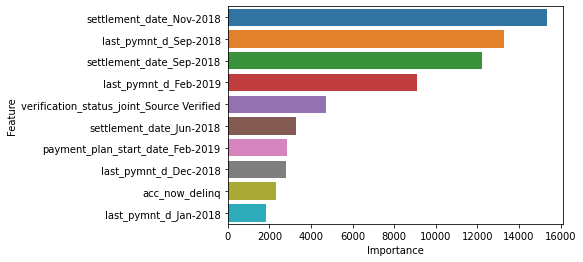

In [41]:
names_num = test_data[numerical_features].columns.values
names_cat = pipe.named_steps['preprocessor'].named_transformers_['categorical'].named_steps["categorical_encoder"].get_feature_names(categorical_features)
names = np.concatenate([names_num, names_cat])
imp = pipe.steps[1][1].feature_importances_
data = pd.DataFrame({'Feature': names, 'Importance': imp})
data = data.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=data);

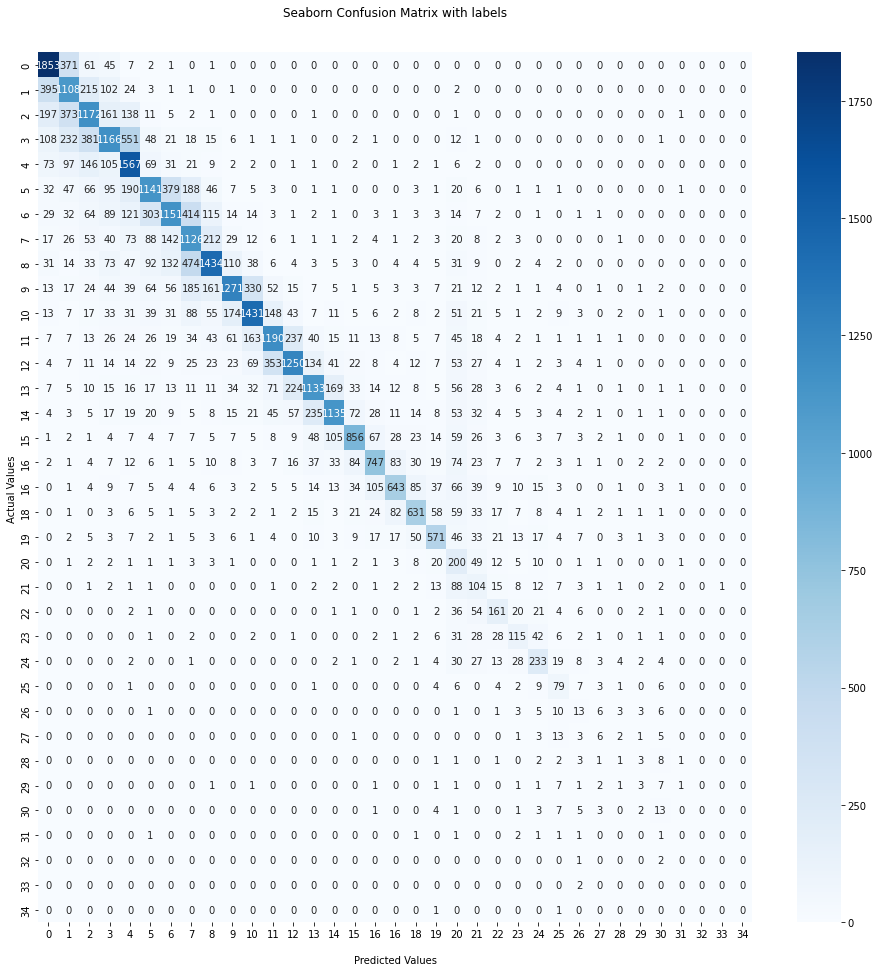

In [42]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])

fig = plt.figure(figsize = (16,16))
confm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confm, annot=True, cmap='Blues',fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels([0, 1, 2, 3, 4, 
                         5, 6, 7, 8, 9, 
                         10, 11, 12, 13, 14,
                         15, 16, 16, 18, 19,
                         20, 21, 22, 23, 24, 
                         25, 26, 27, 28, 29, 
                         30, 31, 32, 33, 34
                        ])
ax.yaxis.set_ticklabels([0, 1, 2, 3, 4, 
                         5, 6, 7, 8, 9, 
                         10, 11, 12, 13, 14,
                         15, 16, 16, 18, 19,
                         20, 21, 22, 23, 24, 
                         25, 26, 27, 28, 29, 
                         30, 31, 32, 33, 34])

plt.show()

## Smaller model

Making smaller model with top 10 features

In [43]:
numerical_features = [

    'fico_range_high', 
    'fico_range_low',
    'funded_amnt',
    'dti_joint',
    'funded_amnt_inv',
    'hardship_amount',
    'hardship_dpd'

]
categorical_features = [

    'verification_status_joint',
    'settlement_date', 
    'payment_plan_start_date'
]
label_column = 'sub_grade'

In [44]:
preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            categorical_transformer,
            categorical_features,
        ),
        (
            "numerical",
            numerical_transformer,
            numerical_features,
        ),
    ]
)

In [45]:
pipe = Pipeline([("preprocessor", preprocessor),
                        ("model", model)])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verification_status_joint',
                                                   'settlement_date',
                                                   'payment_plan_start_date']),
                                                 ('numerical',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleImputer(fill_value=-999999,
                          

In [46]:
%%time
pipe.fit(
    train_data[numerical_features + categorical_features], train_data[label_column]
)

CPU times: user 1min 43s, sys: 737 ms, total: 1min 44s
Wall time: 26.8 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verification_status_joint',
                                                   'settlement_date',
                                                   'payment_plan_start_date']),
                                                 ('numerical',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleImputer(fill_value=-999999,
                          

In [47]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])
y_pred_prob = pipe.predict_proba(test_data[numerical_features + categorical_features])
print_results(y_pred, y_test, y_pred_prob)

Test accuracy score: 0.06445
Test precision score: 0.06445
Test ROC AUC score: 0.6399145709568774


In [48]:
import joblib

filename = 'subgradeModel.joblib'
joblib.dump(pipe, filename)

['subgradeModel.joblib']

In [49]:
test_data[numerical_features + categorical_features].head(10)

,fico_range_high,fico_range_low,funded_amnt,dti_joint,funded_amnt_inv,hardship_amount,hardship_dpd,verification_status_joint,settlement_date,payment_plan_start_date
1390589,719.0,715.0,8000.0,NaN,8000.0,NaN,NaN,NaN,NaN,NaN
510725,689.0,685.0,10000.0,NaN,10000.0,NaN,NaN,NaN,NaN,NaN
1509983,734.0,730.0,25000.0,NaN,25000.0,NaN,NaN,NaN,NaN,NaN
1415475,709.0,705.0,5000.0,NaN,5000.0,NaN,NaN,NaN,NaN,NaN
1469253,699.0,695.0,10400.0,NaN,10400.0,NaN,NaN,NaN,NaN,NaN
844802,764.0,760.0,23000.0,NaN,23000.0,NaN,NaN,NaN,NaN,NaN
1422618,669.0,665.0,17000.0,NaN,17000.0,NaN,NaN,NaN,NaN,NaN
778178,674.0,670.0,6400.0,NaN,6400.0,NaN,NaN,NaN,NaN,NaN
847826,714.0,710.0,3000.0,NaN,3000.0,NaN,NaN,NaN,NaN,NaN
495669,714.0,710.0,10000.0,NaN,10000.0,NaN,NaN,NaN,NaN,NaN
